In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import bz2
from tqdm import tqdm
import os

In [3]:
events = []
total_size = 0
for file_name in tqdm(os.listdir('../Data/')):
    if 'txt.bz2' in file_name:
        with bz2.open('../Data/{}'.format(file_name), 'r') as f:
            file = f.readlines()
            print('total shape of {} is ({}, {})'.format(file_name, len(file), len(file[0].split())))
            event_matrix = np.zeros((len(file), len(file[0].split())), dtype=np.int16)
            for ind, event in enumerate(file):
                event_matrix[ind, :] = [int(i) for i in event.split()]
            local_size = event_matrix.size * event_matrix.itemsize / 1024 / 1024 / 1024 # ~250 MB
            total_size += local_size
            print('Total size {}\t Local size {}'.format(total_size, local_size))
            events.append(event_matrix)

  0%|          | 0/14 [00:00<?, ?it/s]

total shape of event0.txt.bz2 is (30720, 4495)


 14%|█▍        | 2/14 [00:55<05:33, 27.80s/it]

Total size 0.2572059631347656	 Local size 0.2572059631347656
total shape of event1.txt.bz2 is (30720, 4495)


 21%|██▏       | 3/14 [01:46<06:21, 34.69s/it]

Total size 0.5144119262695312	 Local size 0.2572059631347656
total shape of event10.txt.bz2 is (30720, 4495)


 29%|██▊       | 4/14 [02:41<06:47, 40.76s/it]

Total size 0.7716178894042969	 Local size 0.2572059631347656
total shape of event2.txt.bz2 is (30720, 4495)


 36%|███▌      | 5/14 [03:34<06:40, 44.55s/it]

Total size 1.0288238525390625	 Local size 0.2572059631347656
total shape of event3.txt.bz2 is (30720, 4495)


 43%|████▎     | 6/14 [04:27<06:17, 47.15s/it]

Total size 1.2860298156738281	 Local size 0.2572059631347656
total shape of event4.txt.bz2 is (30720, 4495)


 50%|█████     | 7/14 [05:23<05:47, 49.66s/it]

Total size 1.5432357788085938	 Local size 0.2572059631347656
total shape of event5.txt.bz2 is (30720, 4495)


 57%|█████▋    | 8/14 [06:16<05:04, 50.72s/it]

Total size 1.8004417419433594	 Local size 0.2572059631347656
total shape of event6.txt.bz2 is (30720, 4495)


 64%|██████▍   | 9/14 [07:06<04:11, 50.36s/it]

Total size 2.057647705078125	 Local size 0.2572059631347656
total shape of event7.txt.bz2 is (30720, 4495)


 71%|███████▏  | 10/14 [07:57<03:22, 50.73s/it]

Total size 2.3148536682128906	 Local size 0.2572059631347656
total shape of event8.txt.bz2 is (30720, 4495)


 79%|███████▊  | 11/14 [08:47<02:31, 50.57s/it]

Total size 2.5720596313476562	 Local size 0.2572059631347656
total shape of event9.txt.bz2 is (30720, 4495)


100%|██████████| 14/14 [09:38<00:00, 41.32s/it]

Total size 2.829265594482422	 Local size 0.2572059631347656


In [4]:
events = np.row_stack(events)

In [8]:
with open('../Data/full_events.npy', 'wb') as f:
    np.save(f, events, allow_pickle=False)

### Start here

In [3]:
with open('../Data/full_events.npy', 'rb') as f:
    events = np.load(f, allow_pickle=False)

In [12]:
events.shape

(337920, 4495)

In [1]:
337920*4495

1518950400

In [15]:
events

array([[    1,     0,     0, ...,  1803,  1800,  1801],
       [    1,     1,     0, ...,  1800,  1800,  1802],
       [    1,     2,     0, ...,  1798,  1798,  1802],
       ...,
       [   10, 30717,     1, ...,   497,   497,   502],
       [   10, 30718,     1, ...,   502,   501,   501],
       [   10, 30719,     1, ...,   499,   496,   500]], dtype=int16)

In [38]:
event_step = 30720
ada_step = 12
collection_step = 960
readout_step = 800

In [18]:
collection_channels = events[events[:, 2] == 1][:, 3:]
readout_channels = events[events[:, 2] == 0][:, 3:]

In [19]:
readout_channels

array([[1799, 1801, 1803, ..., 1803, 1800, 1801],
       [1802, 1796, 1803, ..., 1800, 1800, 1802],
       [1799, 1800, 1800, ..., 1798, 1798, 1802],
       ...,
       [1801, 1801, 1798, ..., 1803, 1799, 1804],
       [1800, 1799, 1799, ..., 1800, 1801, 1802],
       [1801, 1803, 1802, ..., 1802, 1797, 1800]], dtype=int16)

In [138]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import ScalarMappable

from sklearn.preprocessing import StandardScaler, QuantileTransformer
import skimage


def plot_plane(adcs, fig, axis, figsize=None, title='pcolormesh with levels'):
    y, x = np.mgrid[slice(0, adcs.shape[1], 1),
                    slice(0, adcs.shape[0], 1)]
    z = adcs.T
    levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())
    cmap = plt.get_cmap('coolwarm')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    axis.set_title(title)
    im = axis.pcolormesh(x, y, z, cmap=cmap, norm=norm)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axis)
#     cbar.ax.set_title("scale")

def max_pool(a, k):
    return skimage.measure.block_reduce(a, (k,k), np.max)

def scale(a):
    return StandardScaler().fit_transform(a)
    
def plot_apa(apa, figsize=None, title='APA#None'):    
    fig, axes = plt.subplots(3, 1, figsize=(30, 50))
    plot_plane(scale(apa[:readout_step]), fig, axes[0],  title=title+' first readout plane')
    plot_plane(scale(apa[readout_step:2*readout_step]), fig, axes[1], title=title+' second readout plane')
    im = plot_plane(scale(apa[2*readout_step:]), fig, axes[2], title=title+' collection plane')
    plt.tight_layout()
#     plt.colorbar()
    plt.show()

In [139]:
plane_num = 10

plane = events[events[:, 0] == plane_num]
plane = plane[:, 3:]

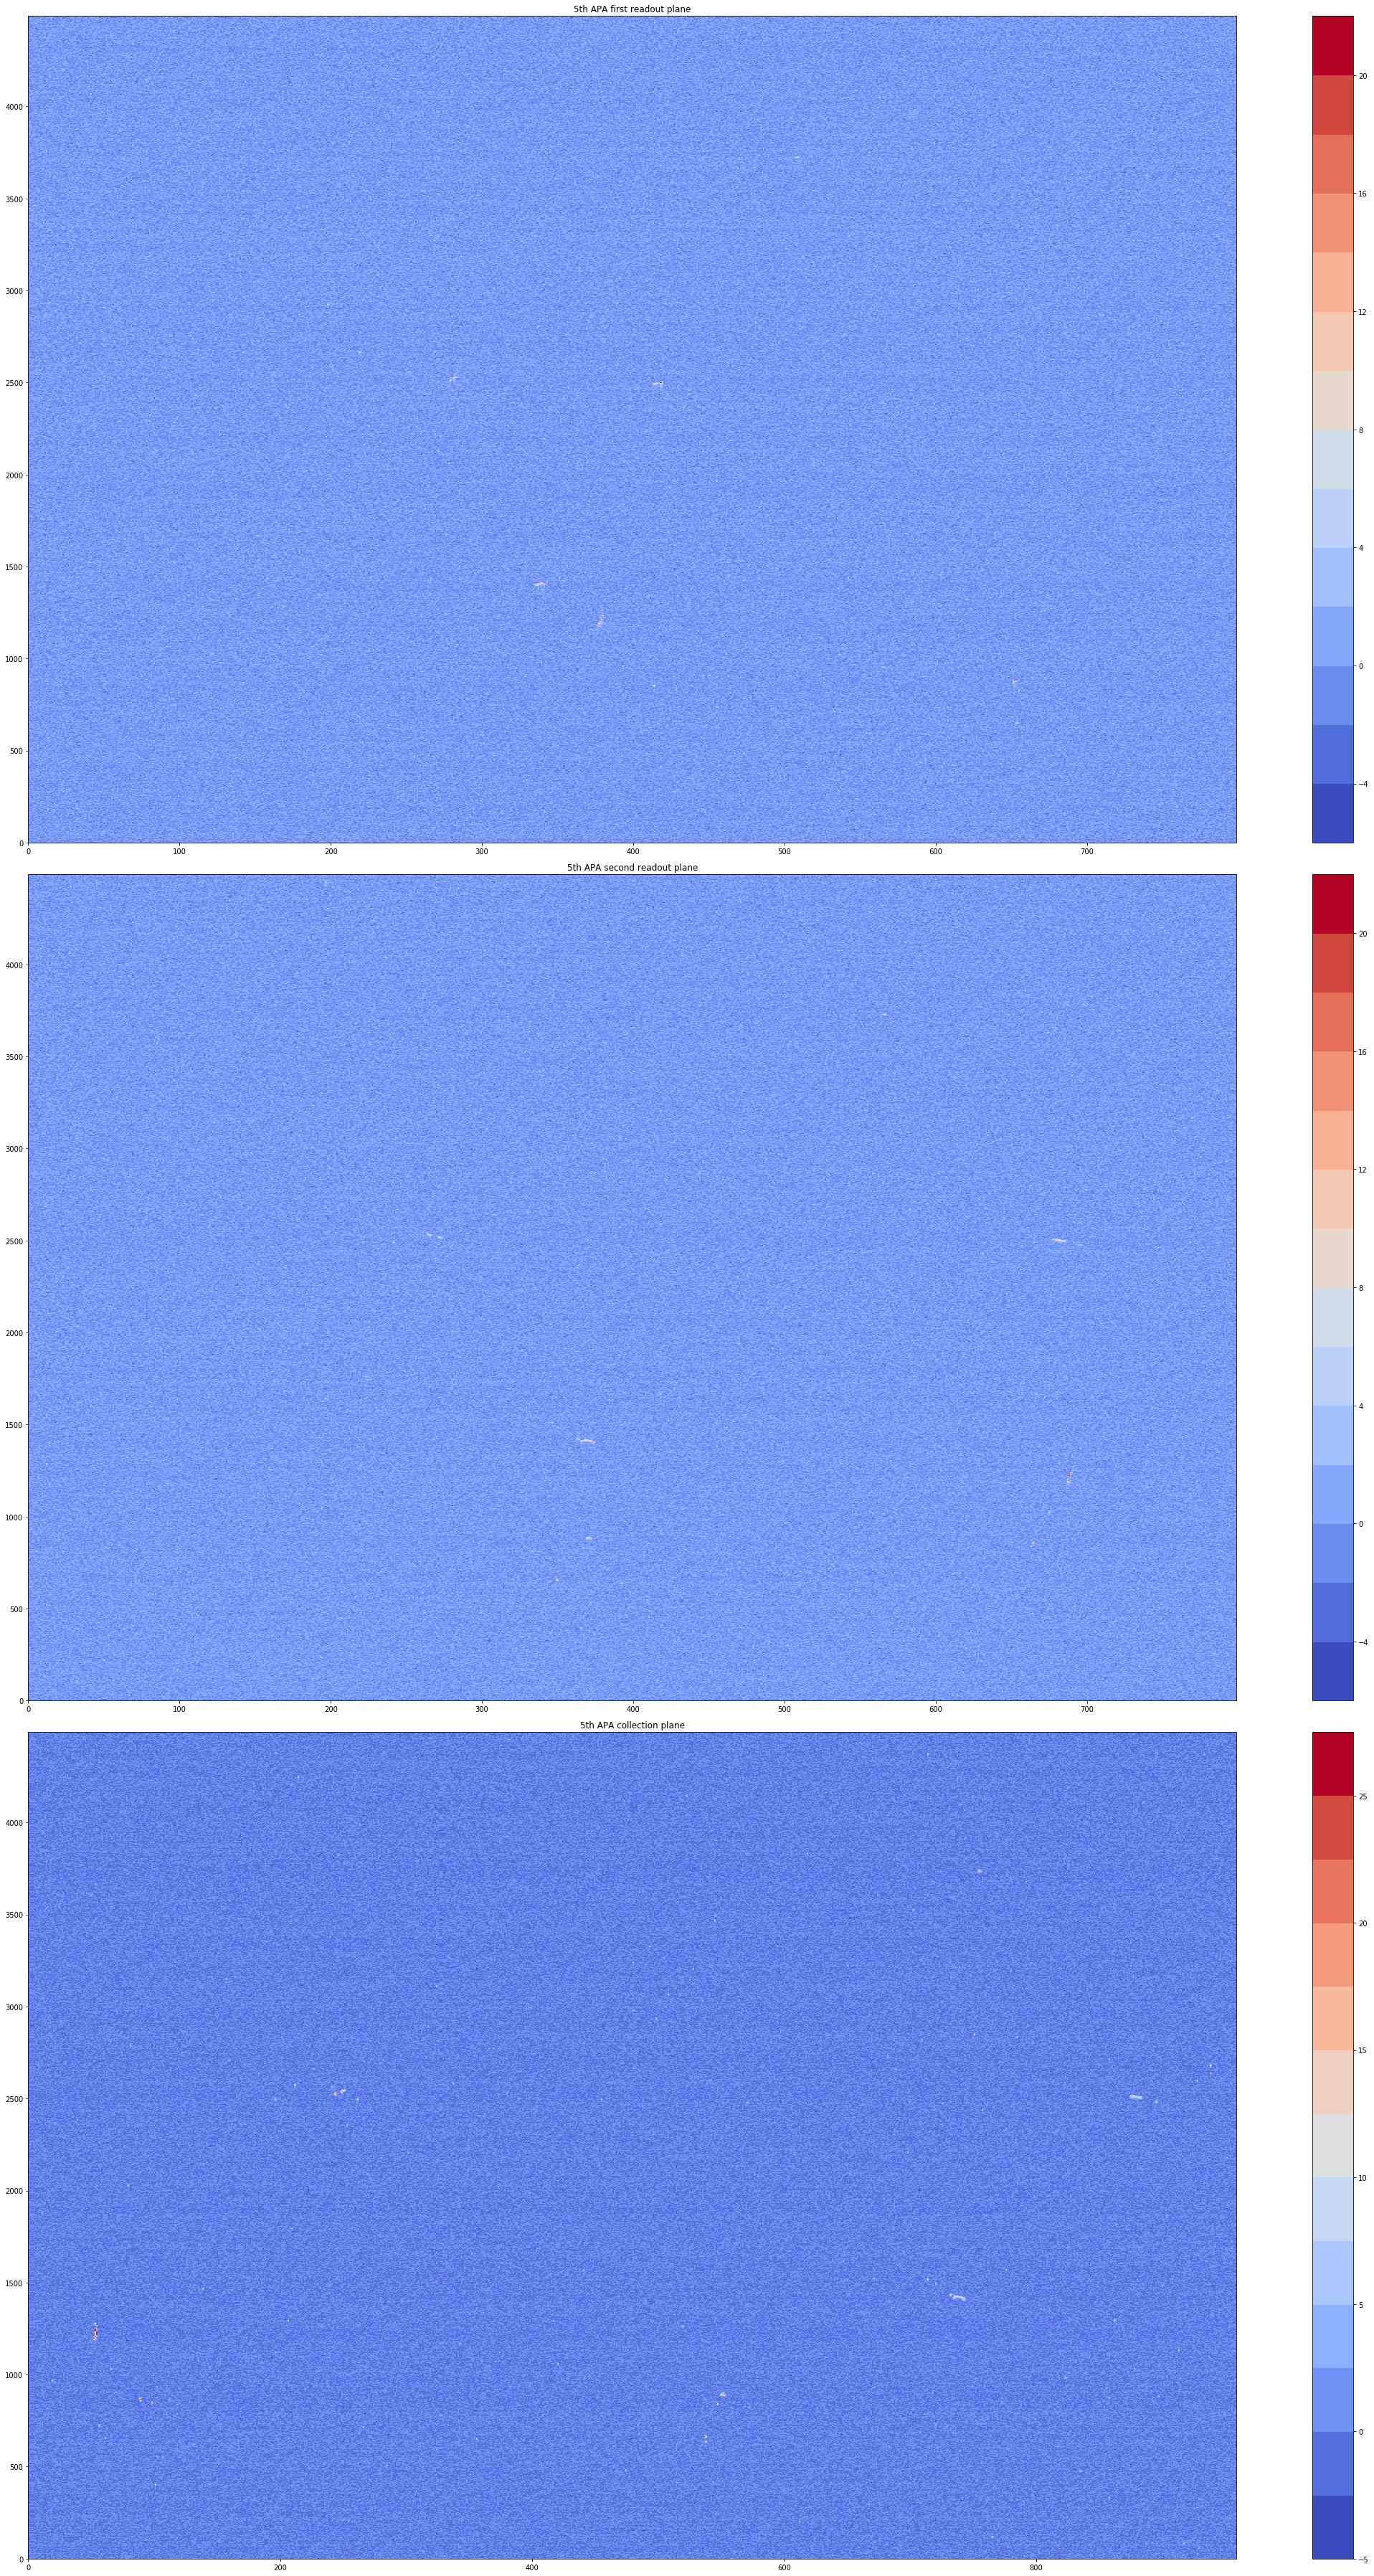

In [140]:
plot_apa(plane[:2*readout_step + collection_step], title='5th APA')

In [182]:
apa = plane[:2*readout_step + collection_step]
readout1 = apa[:readout_step]

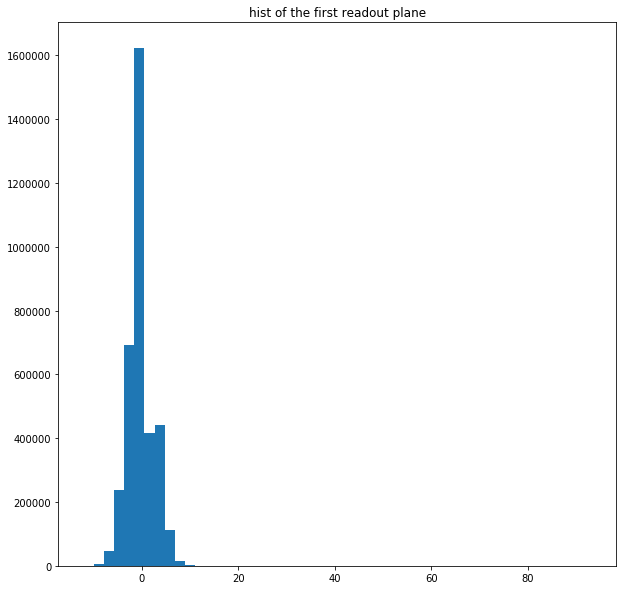

In [183]:
plt.figure(figsize=(10, 10))
plt.title('hist of the first readout plane')
plt.hist(readout1.reshape(-1), bins=50)
plt.show()

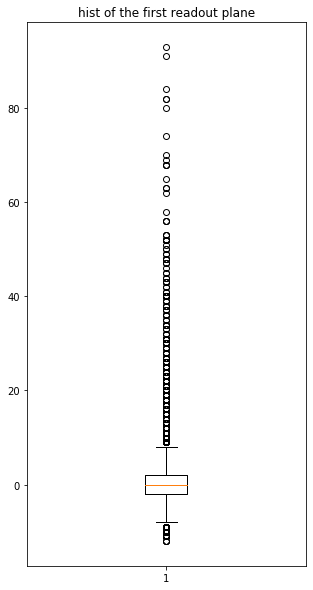

In [184]:
plt.figure(figsize=(5, 10))
plt.title('hist of the first readout plane')
plt.boxplot(readout1.reshape(-1))
plt.show()

In [185]:
readout1 -= readout1.mean().astype(np.int16)

In [186]:
readout1[np.logical_and(readout1 < np.percentile(readout1, 85), readout1 > np.percentile(readout1, 15))] = 0

In [187]:
def plot_plane_simple(adcs, title=''):
    plt.figure(figsize=(15, 15))
    y, x = np.mgrid[slice(0, adcs.shape[1], 1),
                    slice(0, adcs.shape[0], 1)]
    z = adcs.T
    levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())
    cmap = plt.get_cmap('coolwarm')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    plt.title(title)
    plt.pcolormesh(x, y, z, cmap=cmap, norm=norm)
    plt.colorbar()
    plt.show()

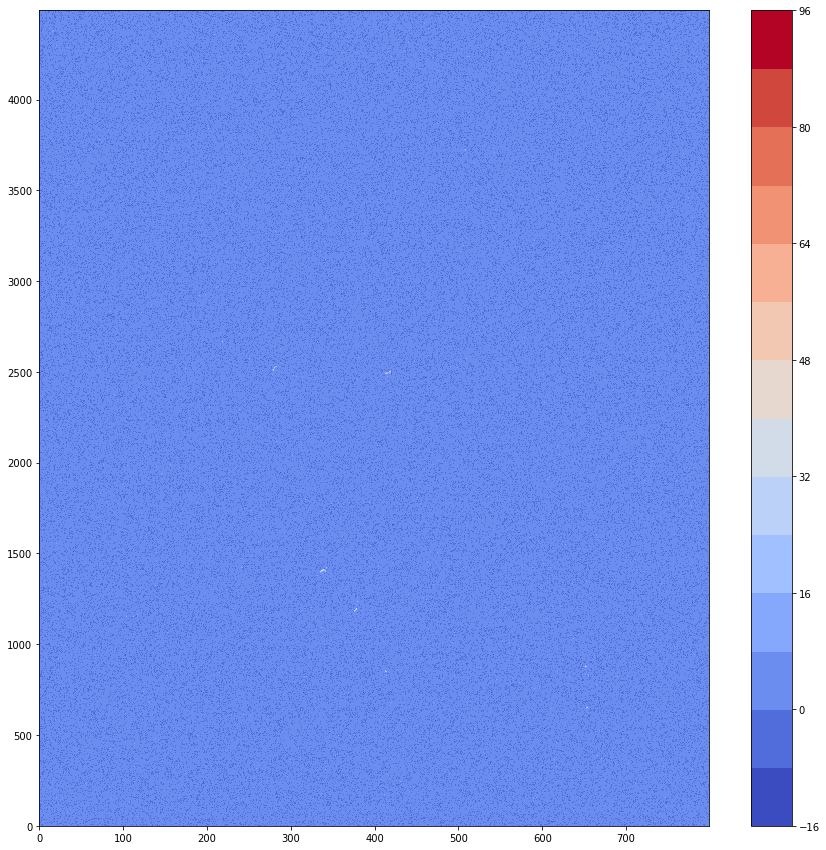

In [188]:
plot_plane_simple(readout1)

In [190]:
!pip3 install torch --user

    100% |████████████████████████████████| 676.9MB 2.0kB/s eta 0:00:01  4% |█▎                              | 27.9MB 30.2MB/s eta 0:00:22    5% |██                              | 40.4MB 26.5MB/s eta 0:00:24    11% |███▌                            | 74.6MB 31.5MB/s eta 0:00:20    18% |██████                          | 126.3MB 25.7MB/s eta 0:00:22    20% |██████▍                         | 136.1MB 25.7MB/s eta 0:00:22    25% |████████▎                       | 174.4MB 31.4MB/s eta 0:00:17    29% |█████████▍                      | 199.1MB 30.3MB/s eta 0:00:16    34% |███████████                     | 234.3MB 39.6MB/s eta 0:00:12    35% |███████████▍                    | 240.8MB 31.9MB/s eta 0:00:14    37% |████████████                    | 251.8MB 46.4MB/s eta 0:00:10    41% |█████████████▍                  | 283.0MB 31.5MB/s eta 0:00:13    42% |█████████████▊                  | 290.7MB 49.1MB/s eta 0:00:08    51% |████████████████▍               | 346.2MB 30.6MB/s eta 0:00:11    66% |████